# Treinamento com interface de alto nível

O objetivo deste notebook é ilustrar o uso da biblioteca `pytorch_trainer` que permite uma programação de mais alto nível.
As principais classes e funções implementadas são:
- DeepNetTrainer
    - **métodos**:
        - fit e fit_loader
        - evaluate e evaluate_loader
        - predict e predict_loader
        - predict_classes e predict_classes_loader
        - predict_probas e predict_probas_loader
        - load_state e save_state

Conceito de **callback**:
- classe DeepNetTrainer:
    - responsável pelo treinamento com praticamente todas as opções possíveis
    - uso de 8 entry points para uso de callbacks:
        - início de treinamento                     :`on_train_begin`
            - início de época                       :`on_epoch_begin`
                - início de minibatch de treinamento:`on_batch_begin`
                - final de minibatch de treinamento :`on_batch_end`
                - início de minibatch de validação  :`on_vbatch_begin`
                - final de minibatch de validação   :`on_vbatch_end`
            - final de época                        :`on_epoch_end`
        - final de treinamento                      :`on_train_end`
- classe Callback
    - permite a implementação de vários callbacks úteis:
        - AccuracyMetric: cálculo da acurácia
        - PrintCallback:  impressão das métricas durante treinamento
        - ModelCheckpoint:salva modelo sempre que loss de validação é melhor

Analise o arquivo da biblioteca `pytorch_trainer`:

In [1]:
%pycat lib/pytorch_trainer.py

## Importação das bibliotecas

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn

import torchvision

import lib.pytorch_trainer as ptt

## Leitura do Dataset

### Carregamento, normalização e seleção dos dados do MNIST


In [3]:
dataset_dir = '/data/datasets/MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')
x_test,  y_test  = torch.load(dataset_dir + 'processed/test.pt')

x_train = x_train.float()
x_test  = x_test.float()

x_train = x_train / 255.
x_test  = x_test  / 255.

### Poucos dados, apenas para depurar experimento

In [4]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]
    x_test  = x_test[:n_samples_test]
    y_test  = y_test[:n_samples_test]

## Criação da rede

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 50)
        self.at1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.at1(x)
        x = self.fc2(x)
        return x
    
model = Model()

## Treinamento

### Criando o objeto de treinamento

A biblioteca 'lib/pytorch_trainer.py' implementa a classe `DeepNetTrainer`, assim como vários *callbacks*:
- ModelCheckpoint: usado para salvar o melhor modelo, de menor Loss
- AccuracyMetric: calcular a acurácia durante o treinamento
- PrintCallback: imprimir dados de cada época durante o treinamento

In [6]:
chkpt_cb = ptt.ModelCheckpoint('../../models/MNIST_neuralnet', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = torch.optim.SGD(model.parameters(),lr=0.03),
                        callbacks = [ptt.AccuracyMetric(),ptt.PrintCallback(),chkpt_cb]
                        )

In [7]:
trainer.fit(20, x_train, y_train, valid_data=(x_test, y_test))

Start training for 20 epochs
  1:   0.1s   T: 1.95322 0.46700   V: 1.59559 0.62200 best
  2:   0.1s   T: 1.12662 0.75200   V: 1.01745 0.73400 best
  3:   0.1s   T: 0.71316 0.83300   V: 0.78004 0.77600 best
  4:   0.1s   T: 0.54542 0.86000   V: 0.65853 0.80000 best
  5:   0.1s   T: 0.45351 0.87800   V: 0.59215 0.81400 best
  6:   0.2s   T: 0.39726 0.88400   V: 0.54202 0.83000 best
  7:   0.1s   T: 0.35218 0.90400   V: 0.53300 0.82000 best
  8:   0.1s   T: 0.31977 0.91300   V: 0.50939 0.83800 best
  9:   0.1s   T: 0.29274 0.92400   V: 0.47999 0.84200 best
 10:   0.1s   T: 0.26698 0.93300   V: 0.48208 0.83200 
 11:   0.1s   T: 0.24804 0.93300   V: 0.45623 0.85400 best
 12:   0.2s   T: 0.22744 0.93900   V: 0.48424 0.83400 
 13:   0.1s   T: 0.21128 0.94200   V: 0.45530 0.84000 best
 14:   0.1s   T: 0.19836 0.95400   V: 0.43916 0.85400 best
 15:   0.1s   T: 0.17928 0.95800   V: 0.43971 0.85600 
 16:   0.1s   T: 0.16567 0.95900   V: 0.47006 0.84800 
 17:   0.1s   T: 0.15779 0.96700   V: 0.445

## Avaliação

### Plotando as métricas do treinamento

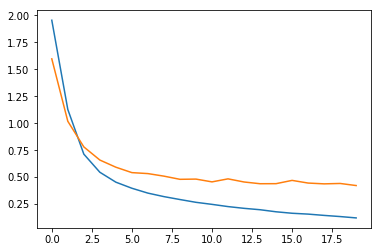

In [8]:
histo_loss_val = trainer.metrics['valid']['losses']
histo_loss_tra = trainer.metrics['train']['losses']
epochs = np.arange(len(histo_loss_val))
plt.plot(epochs,histo_loss_tra, epochs,histo_loss_val);

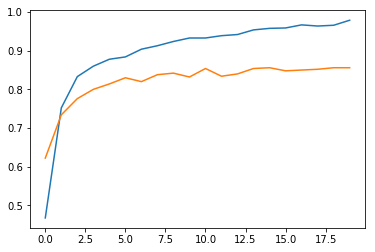

In [9]:
histo_acc_val = trainer.metrics['valid']['acc']
histo_acc_tra = trainer.metrics['train']['acc']
epochs = np.arange(len(histo_acc_val))
plt.plot(epochs,histo_acc_tra, epochs,histo_acc_val);

### Recuperando o modelo da melhor época

In [10]:
trainer.load_state('../../models/MNIST_neuralnet')

### Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de validação

Uso do `trainer.evaluate`

In [11]:
acc_train = trainer.evaluate(x_train,y_train, metrics=[ptt.AccuracyMetric()])
acc_val = trainer.evaluate(x_test,y_test, metrics=[ptt.AccuracyMetric()])

print('Training Accuracy:   {:f}'.format(acc_train['acc']))
print('Validation Accuracy: {:f}'.format(acc_val['acc']))

evaluate: 99/99 ok
evaluate: 49/49 ok
Training Accuracy:   0.981000
Validation Accuracy: 0.856000


### Matriz de confusão com dados de treinamento e validação

Uso do `trainer.predict_classes`

In [12]:
y_pred     = trainer.predict_classes(x_train)
y_val_pred = trainer.predict_classes(x_test)

In [13]:
pd.crosstab(y_pred.cpu().numpy(),y_train.cpu().numpy())

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,97,0,0,0,0,0,0,0,0,1
1,0,113,1,0,0,0,0,0,0,0
2,0,1,97,1,0,1,0,0,0,0
3,0,0,0,91,0,0,0,0,0,0
4,0,0,0,0,103,0,0,0,0,1
5,0,0,0,1,0,89,0,0,0,1
6,0,0,0,0,1,1,94,0,0,0
7,0,0,0,0,0,0,0,117,0,3
8,0,2,0,0,0,1,0,0,87,1


In [14]:
pd.crosstab(y_val_pred.cpu().numpy(),y_test.cpu().numpy())

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,42,0,1,0,0,1,1,0,1,0
1,0,67,0,0,0,1,0,0,0,0
2,0,0,47,2,0,1,2,3,1,0
3,0,0,1,34,0,1,0,3,0,3
4,0,0,1,0,47,0,1,1,1,0
5,0,0,0,8,0,37,3,0,1,0
6,0,0,1,0,3,1,36,0,0,0
7,0,0,3,1,0,3,0,40,2,4
8,0,0,1,0,0,5,0,0,32,1


## Exercícios

1. Implemente e teste uma nova classe de callback para imprimir o número do minibatch e o número da época durante o treinamento.
2. Implemente e teste uma classe de callback para imprimir o valor médio e a variância dos pesos da primeira camada da rede à medida que ela é treinada.

## Aprendizados